In [2]:
import numpy as np
import torch
import time
import copy
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

sys.path.append('..')
from networks.mnist_network import Net
from dataloader.dataset_wrapper import mydata
from sklearn.model_selection import KFold


sns.set_theme()

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
m = 30
N = 5000
mean = np.zeros(m**2)
cov = np.zeros((m**2, m**2))
theta = 2
for i1 in range(30):
    for j1 in range(30):
        for i2 in range(30):
            for j2 in range(30):
                cov[i1*30+j1, i2*30+j2] = np.exp(-((i1-i2)**2+(j1-j2)**2)/theta)
                
ind1 = np.zeros((m, m))
ind2 = np.zeros((m, m))
for i in range(30):
    for j in range(30):
        if ((3<=i<=10) and (3<=j<=10)):
            ind1[i,j] = 1
        if (17<=j<=27 and 21<=i<=26 and abs(i-21)>=abs(j-22)):
            ind2[i,j] = 1
ind1 = ind1.reshape(1, -1)
ind2 = ind2.reshape(1, -1)
ind = (ind1+ind2).reshape(1, -1)

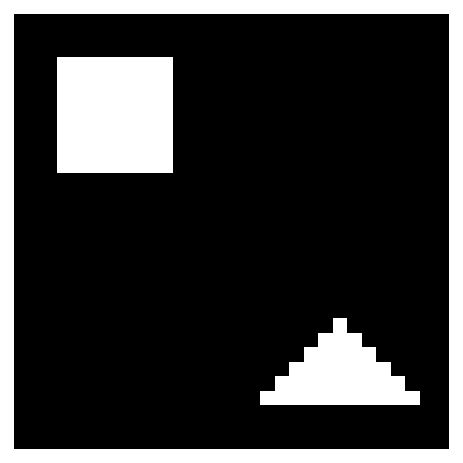

In [4]:
import matplotlib.pyplot as plt
plt.imshow(ind.reshape(30, 30), cmap='gray')
plt.axis('off')
#plt.savefig('figures/region_A_B.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
## same as 
##  grids = GP.GP_generate_grids(d=2, num_grids=30)
##  phi = GP.GP_eigen_funcs_fast(grids, a=0.01, b = 10, poly_degree = 10)
phi = np.loadtxt('../phi/mse_a0.01_b10.csv')

In [7]:
seeds = np.array([  1,   2,   4,   8,   9,  11,  13,  17,  18,  21,  22,  23,  24,
        28,  29,  31,  33,  34,  37,  39,  40,  43,  45,  48,  49,  50,
        51,  53,  54,  55,  57,  58,  60,  62,  63,  64,  65,  66,  68,
        69,  71,  73,  74,  75,  76,  78,  79,  80,  82,  83,  84,  85,
        86,  88,  89,  90,  91,  92,  93,  94,  95,  97,  98, 100, 101,
       102, 104, 105])

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
grad = []
for (x, w), y in train_loader:
    x = x.to(device)
    x.requires_grad = True
    w = w.to(device)
    for i in range(x.shape[0]):
        log_odds = net.model(x[[i]], w[[i]])
        log_odds.sum().backward()
    grad.append(copy.deepcopy(x.grad))
grad = torch.cat(grad, axis=0)

In [46]:
val = torch.abs(grad).sum(axis=0)

In [49]:
(val>0).sum()

tensor(213, device='cuda:0')

### Different lambda

In [ ]:
for lamb in [0, 1, 2, 3, 4, 5, 6, 7]:
    
    print(f'lamb={lamb}')
    
    n_epochs = 5000
    n_train = 200
    N = 5000
    n_test = N-n_train
    print_every = test_every = 200
    start_save = n_epochs * 0.8
    save_every = 10
    N_saves = 50
    n_seeds = 200
    K = 5
    
    
    beta = np.zeros([n_seeds, N_saves, 30*30])
    best_accu = np.zeros(n_seeds)
    count = 0
    
    for seed in tqdm(range(n_seeds)):

        np.random.seed(seed)
        torch.manual_seed(seed)


        X = np.random.multivariate_normal(mean, cov, size=N)
        X = (X/2 + ind * np.random.randn(N, 900)/2).astype(np.float32)

        Y = (-2 + 6 * np.sin(1+3*(X*ind1).sum(axis=1)/ind1.sum()) - 3 * np.exp((X*ind2).sum(axis=1)/ind2.sum())>0).astype(int)
        count += 1

        train_dat = mydata(X[:200], Y[:200])
        val_dat = mydata(X[200:], Y[200:])
        train_loader = DataLoader(train_dat, batch_size=100, shuffle=True)
        val_loader = DataLoader(val_dat, batch_size=1000, shuffle=True)

        net = Net(lr=1e-3, input_dim=900, n_hid=K, output_dim=1, w_dim=1, n_knots=phi.shape[1],
                  N_train=200, phi=torch.tensor(phi, dtype=torch.float32), lamb=lamb, langevin=True,
                  step_decay_epoch=2500, step_gamma=1., act='relu')
        n_param = 0
        for param in net.model.parameters():
            n_param += param.numel()

        loss_train = np.zeros(n_epochs)
        accu_train = np.zeros(n_epochs)

        loss_val = np.zeros(n_epochs)
        accu_val = np.zeros(n_epochs)

        for i in range(n_epochs):

            tic = time.time()
            net.scheduler.step()

            for (x, w), y in train_loader:
                loss, accu = net.fit(x, w, y)
                loss_train[i] += loss
                accu_train[i] += accu

            loss_train[i] /= n_train
            accu_train[i] /= n_train
            toc = time.time()

            if i % print_every == 0:
                pass
                #print('Epoch %d, train time %.4f s, train loss %.4f, train accuracy %.2f%%' % (i, toc - tic, loss_train[i], accu_train[i] * 100))

            if i > start_save and i % save_every == 0:
                net.save_net_weights(max_samples=N_saves)

            if i % test_every == 0:
                with torch.no_grad():
                    tic = time.time()
                    for (x, w), y in val_loader:
                        loss, accu = net.eval(x, w, y)

                        loss_val[i] += loss
                        accu_val[i] += accu

                    loss_val[i] /= n_test
                    accu_val[i] /= n_test
                    toc = time.time()
                    best_accu[seed] = max(best_accu[seed], accu_val[i])


        for j, weight_dict in enumerate(net.weight_set_samples):
            net.model.load_state_dict(weight_dict)
            grad = []
            for (x, w), y in train_loader:
                x = x.to(device)
                x.requires_grad = True
                w = w.to(device)
                for i in range(x.shape[0]):
                    log_odds = net.model(x[[i]], w[[i]])
                    log_odds.sum().backward()
                grad.append(copy.deepcopy(x.grad))
            grad = torch.cat(grad, axis=0)
            beta[seed, j] = (torch.abs(grad).mean(axis=0) > 0.001).numpy()
            
    b = beta.mean(axis=1)
    np.save(f'../save_model/b_{lamb}.npy', b)

In [6]:
def bayesian_selection(b, alpha=0.01):
    b_copy = copy.deepcopy(b)
    for i in range(b.shape[0]):
        tmp = sorted(copy.deepcopy(b[i]), reverse=True)
        s = 0
        for j in range(len(tmp)):
            s += (1-tmp[j])
            if s / (j+1) > alpha:
                break
        b_copy[i][b_copy[i] >= tmp[j]] = 1.
        b_copy[i][b_copy[i] < tmp[j]] = 0.
    return b_copy

In [7]:
b = []
b_s = []
lambs = [0,1,2,3,4,5,6,7]
for lamb in lambs:
    b.append(np.load(f'save_model/b_{lamb}.npy'))
    b_s.append(bayesian_selection(b[-1]))

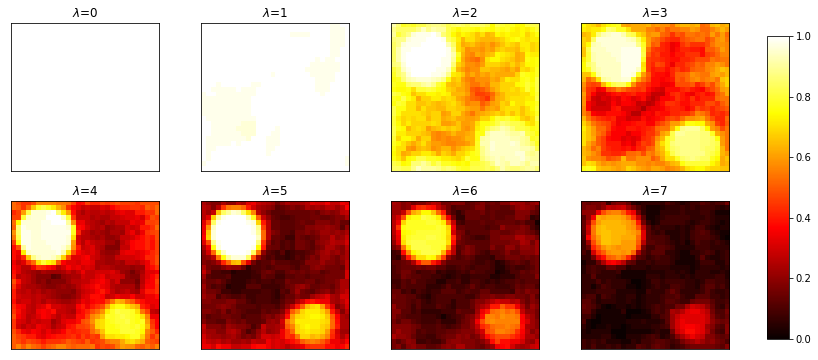

In [14]:
fig, ax = plt.subplots(figsize=(15,6), nrows=2, ncols=4)
for i, lamb in enumerate(lambs):
    i_ = i//4
    j_ = i%4
    im = ax[i_][j_].imshow(b_s[i].mean(0).reshape(30,30), cmap='hot', vmin=0, vmax=1)
    ax[i_][j_].set_title(f'$\lambda$={lamb}')
    ax[i_][j_].get_xaxis().set_visible(False)
    ax[i_][j_].get_yaxis().set_visible(False)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('figures/simulation_lambda_stability.png', dpi=300, bbox_inches='tight')
plt.show()

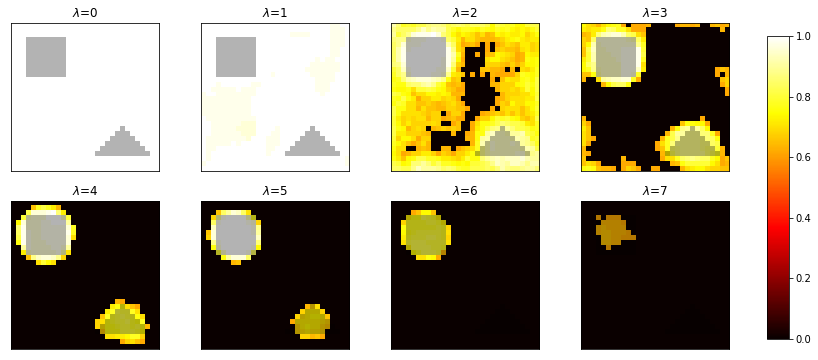

In [15]:
fig, ax = plt.subplots(figsize=(15,6), nrows=2, ncols=4)
for i, lamb in enumerate(lambs):
    i_ = i//4
    j_ = i%4
    idx = b_s[i].mean(0)>0.6
    tmp = b_s[i].mean(0)
    tmp[~idx]=0
    masked = np.ma.masked_where(ind == 0, ind)
    im = ax[i_][j_].imshow(tmp.reshape(30,30), cmap='hot', vmin=0, vmax=1)
    ax[i_][j_].imshow(masked.reshape(30, 30), cmap='gray', alpha=0.3)
    ax[i_][j_].set_title(f'$\lambda$={lamb}')
    ax[i_][j_].get_xaxis().set_visible(False)
    ax[i_][j_].get_yaxis().set_visible(False)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('figures/simulation_lambda_stability_0.6.png', dpi=300, bbox_inches='tight')
plt.show()